# Time series prediction with LSTM - univariate model

## Importing libraries

In [1]:
import math
import matplotlib.pyplot   as plt
import numpy               as np
import pandas              as pd
import pandas_datareader   as web
import requests
import sys
import tensorflow          as tf

from tensorflow                     import keras
from tensorflow.python.keras.layers import BatchNormalization, Conv1D, Dense, Flatten, Input, LSTM, MaxPooling1D, TimeDistributed, UpSampling1D
from tensorflow.python.keras.models import Model, Sequential
from pathlib                        import Path

from numpy                          import array
from sklearn.preprocessing          import MinMaxScaler

D:\Archivos_programas\Anaconda\envs\machine_learning\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#### Graphics style

In [2]:
plt.style.use('fivethirtyeight')

#### App paths

In [3]:
app_folder = Path.cwd()
model_folder = app_folder / "saved_model_and_weights"
input_folder = app_folder / "input_files"
target_folder = app_folder / "target_files"
resource_file = input_folder / "datos-tipo-cambio-usd-futuro-dolar-frecuencia-diaria.csv"

## Data download

### Download most recent data from datos.gob.ar

In [4]:
def download_resource():
    url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/168/distribution/168.1/download/datos-tipo-cambio-usd-futuro-dolar-frecuencia-diaria.csv'
    myfile = requests.get(url)

    with open(resource_file, 'wb') as f:
        f.write(myfile.content)
        
download_resource()

## Part 1: Forecast a univariate time series

### Data preparation

#### Dataframe creation

In [5]:
df = pd.read_csv(resource_file)
df

,indice_tiempo,tipo_cambio_bna_vendedor,tipo_cambio_a3500,tipo_cambio_mae,volumen_mae,tipo_cambio_implicito_en_adrs,futuro_rofex_usd1m,interes_abierto_1m,futuro_rofex_usd2m,interes_abierto_2m,futuro_rofex_usd3m,interes_abierto_3m,futuro_rofex_usd4m,interes_abierto_4m,futuro_rofex_usd5m,interes_abierto_5m,futuro_rofex_usd6m,interes_abierto_6m
0,2002-03-05,NaN,1.9917,NaN,NaN,2.180124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-03-06,NaN,2.0508,NaN,NaN,2.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-03-07,NaN,2.1375,NaN,NaN,2.343949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-03-08,NaN,2.2033,NaN,NaN,2.227778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-03-09,NaN,2.2033,NaN,NaN,2.227778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6719,2020-07-27,75.75,72.0750,72.08,141640.0,118.167580,72.31,1668651.0,74.60,1489806.0,77.14,613129.0,79.83,307165.0,82.88,119175.0,86.20,132713.0
6720,2020-07-28,76.00,72.1350,72.14,75100.0,119.558101,72.31,1579939.0,74.60,1609124.0,77.13,608529.0,79.83,307759.0,82.88,115946.0,86.21,138657.0
6721,2020-07-29,76.00,72.1950,72.20,85150.0,118.465909,72.31,1521307.0,74.61,1690945.0,77.15,619397.0,79.85,333348.0,82.90,132868.0,86.23,150381.0
6722,2020-07-30,76.00,72.2550,72.26,88010.0,121.369637,72.31,1296463.0,74.60,1907247.0,77.13,660067.0,79.81,347768.0,82.85,135322.0,86.15,136319.0


#### Multivariate features parsing

In [6]:
features_considered = ['tipo_cambio_bna_vendedor', 
                       'tipo_cambio_a3500', 
                       'tipo_cambio_mae', 
                       'volumen_mae', 
                       'tipo_cambio_implicito_en_adrs', 
                       'futuro_rofex_usd1m', 
                       'interes_abierto_1m', 
                       'futuro_rofex_usd2m', 
                       'interes_abierto_2m', 
                       'futuro_rofex_usd3m', 
                       'interes_abierto_3m', 
                       'futuro_rofex_usd4m', 
                       'interes_abierto_4m', 
                       'futuro_rofex_usd5m', 
                       'interes_abierto_5m', 
                       'futuro_rofex_usd6m', 
                       'interes_abierto_6m']

multivariate_dataframe       = df[features_considered]
multivariate_dataframe.index = df['indice_tiempo']

print(multivariate_dataframe.shape)

(6724, 17)


#### Replace NULLS with zeroes

In [7]:
np.nan_to_num(multivariate_dataframe, False)

array([[0.00000e+00, 1.99170e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 2.05080e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 2.13750e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [7.60000e+01, 7.21950e+01, 7.22000e+01, ..., 1.32868e+05,
        8.62300e+01, 1.50381e+05],
       [7.60000e+01, 7.22550e+01, 7.22600e+01, ..., 1.35322e+05,
        8.61500e+01, 1.36319e+05],
       [7.62500e+01, 7.23150e+01, 7.23200e+01, ..., 1.38207e+05,
        8.60500e+01, 1.48556e+05]])

In [8]:
multivariate_dataframe

,tipo_cambio_bna_vendedor,tipo_cambio_a3500,tipo_cambio_mae,volumen_mae,tipo_cambio_implicito_en_adrs,futuro_rofex_usd1m,interes_abierto_1m,futuro_rofex_usd2m,interes_abierto_2m,futuro_rofex_usd3m,interes_abierto_3m,futuro_rofex_usd4m,interes_abierto_4m,futuro_rofex_usd5m,interes_abierto_5m,futuro_rofex_usd6m,interes_abierto_6m
indice_tiempo,,,,,,,,,,,,,,,,,
2002-03-05,0.00,1.9917,0.00,0.0,2.180124,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
2002-03-06,0.00,2.0508,0.00,0.0,2.222222,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
2002-03-07,0.00,2.1375,0.00,0.0,2.343949,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
2002-03-08,0.00,2.2033,0.00,0.0,2.227778,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
2002-03-09,0.00,2.2033,0.00,0.0,2.227778,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,75.75,72.0750,72.08,141640.0,118.167580,72.31,1668651.0,74.60,1489806.0,77.14,613129.0,79.83,307165.0,82.88,119175.0,86.20,132713.0
2020-07-28,76.00,72.1350,72.14,75100.0,119.558101,72.31,1579939.0,74.60,1609124.0,77.13,608529.0,79.83,307759.0,82.88,115946.0,86.21,138657.0
2020-07-29,76.00,72.1950,72.20,85150.0,118.465909,72.31,1521307.0,74.61,1690945.0,77.15,619397.0,79.85,333348.0,82.90,132868.0,86.23,150381.0


#### Selecting univariate feature

In [9]:
univariate_dataframe = multivariate_dataframe['tipo_cambio_a3500']
print(univariate_dataframe.shape)

(6724,)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017014956888>],
      dtype=object)

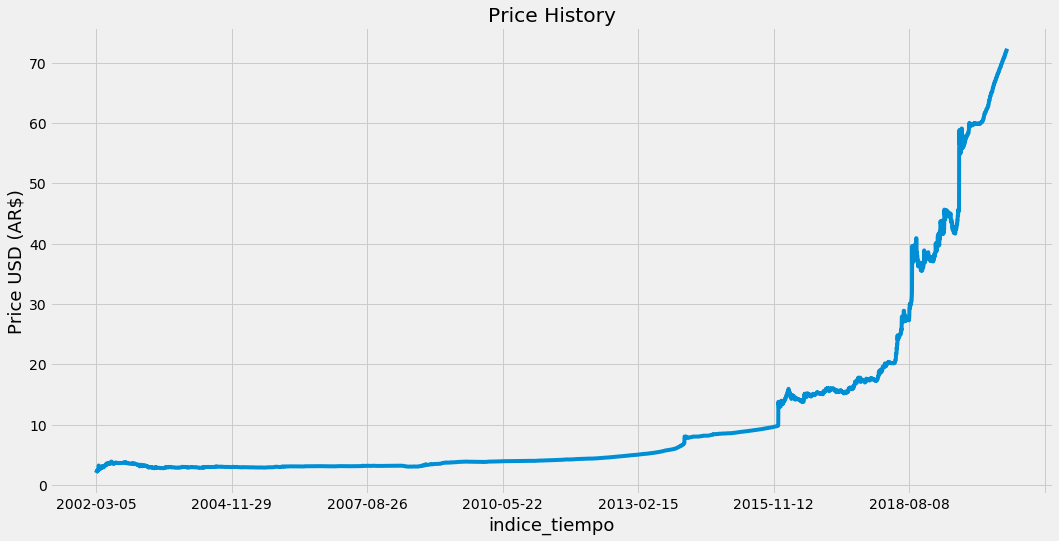

In [10]:
plt.figure(figsize=(16,8))
plt.title('Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD (AR$)', fontsize=18)

univariate_dataframe.plot(subplots=True)

In [11]:
univariate_dataset = univariate_dataframe.values

### Data normalization

In [12]:
univariate_dataset = tf.expand_dims(univariate_dataset, 1)

#### Fit transform

In [13]:
transformer = MinMaxScaler()
transformer.fit(univariate_dataset)

MinMaxScaler(copy=True, feature_range=(0, 1))

#### Difference transform

In [14]:
transformed = transformer.transform(univariate_dataset)
print(transformed)

[[0.00000000e+00]
 [8.40404247e-04]
 [2.07328154e-03]
 ...
 [9.98293595e-01]
 [9.99146798e-01]
 [1.00000000e+00]]


In [15]:
print(transformed.shape)

(6724, 1)


### Generating training and validation arrays

In [16]:
TRAIN_SPLIT = math.ceil( len(univariate_dataset) * 0.95 )

In [17]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data, labels = [], []
    
    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        end_idx = range(i - history_size, i)
        
        # Gather input and output parts of the pattern
        seq_data, seq_labels = dataset[end_idx].reshape((history_size, 1)), dataset[i+target_size]
                
        data.append(seq_data)
        labels.append(seq_labels)
                        
    return np.array(data), np.array(labels)

In [18]:
univariate_past_history = 30
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(transformed, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(transformed, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

In [19]:
BATCH_SIZE          = len(x_train_uni)
BUFFER_SIZE         = len(univariate_dataset)
ENCODING_DIM        = x_train_uni.shape[2]
EPOCHS              = 500
EVALUATION_INTERVAL = 30
TIME_STEPS          = x_train_uni.shape[1]
VALIDATION_STEPS    = x_train_uni.shape[1]
WINDOW_LENGTH       = x_train_uni.shape[1]

In [20]:
print ('Train dataset')
print (x_train_uni.shape)
print (y_train_uni.shape)
print ('\nValidation dataset')
print (x_val_uni.shape)
print (y_val_uni.shape)

Train dataset
(6358, 30, 1)
(6358, 1)

Validation dataset
(305, 30, 1)
(305, 1)


##### Data format:

    (batch_size, time_steps, features)

##### Organization of data:
    
    Train dataset      --> (6358, 30, 1) ==> 6358 days samples every 30 days vector of 1 feature.
                            Range of years between 2002 and 2019.
    
    Validation dataset --> (305, 30, 1) ==> 305 days samples every 30 days vector of 1 feature.
                            From begining of 2020 to the present.
    

In [21]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[0.        ]
 [0.0008404 ]
 [0.00207328]
 [0.00300896]
 [0.00300896]
 [0.00300896]
 [0.00370859]
 [0.00530834]
 [0.00483481]
 [0.00530834]
 [0.00496422]
 [0.00496422]
 [0.00496422]
 [0.00463289]
 [0.00549747]
 [0.00626108]
 [0.00563967]
 [0.00819927]
 [0.00819927]
 [0.00819927]
 [0.01725317]
 [0.01422004]
 [0.01222923]
 [0.01222923]
 [0.01222923]
 [0.01222923]
 [0.01222923]
 [0.01222923]
 [0.01273831]
 [0.01296299]]

 Target to predict
[0.00969238]


### Preprocessing preparation of the train and test sequences as tensor slices

In [22]:
x_train_uni_xd = tf.expand_dims(x_train_uni, 3)
x_val_uni_xd = tf.expand_dims(x_val_uni, 3)

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni_xd, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni_xd, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

tf.compat.v1.data.get_output_shapes(train_univariate)
tf.compat.v1.data.get_output_shapes(val_univariate)

(TensorShape([None, 30, 1, 1]), TensorShape([None, 1]))

### Model definition

In [23]:
tf.random.set_seed(13)

In [24]:
def time_distributed_lstm():
    
    model = Sequential()
    
    model.add(TimeDistributed(Conv1D(filters=128, 
                             kernel_size=1, 
                             kernel_regularizer=keras.regularizers.l2(0.0001), 
                             bias_regularizer=keras.regularizers.l2(0.0001), 
                             activation='relu'), 
                             input_shape=(x_train_uni_xd.shape[1:])))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, 
                   kernel_regularizer=keras.regularizers.l2(0.0001), 
                   recurrent_regularizer=keras.regularizers.l2(0.0001), 
                   bias_regularizer=keras.regularizers.l2(0.0001), 
                   activation='relu', 
                   return_sequences=True))
    model.add(LSTM(64, 
                   return_sequences=False))
    model.add((Dense(64)))
    model.add((Dense(1)))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [25]:
univariate_ts_model = time_distributed_lstm()

In [26]:
univariate_ts_model.summary(line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
time_distributed (TimeDistributed)                    (None, 30, 1, 128)                              256               
________________________________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)                  (None, 30, 1, 128)                              0                 
________________________________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)                  (None, 30, 128)                                 0                 
________________________________________________________________________________________________________________________
lstm (LSTM) 

### Load model

#### We can load the weights of the previous trainings to avoid spending a considerable amount of time on re-training the model in future executions.

In [27]:
#univariate_ts_model.load_weights("time_distributed_lstm_model_weights.h5")

### Model training

##### The patience parameter is the amount of epochs to check for improvement

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = univariate_ts_model.fit(x=train_univariate,
                                  epochs=EPOCHS, 
                                  verbose=1, 
                                  callbacks=[early_stop],
                                  validation_split=0.0, 
                                  validation_data=val_univariate, 
                                  shuffle=True, 
                                  class_weight=None, 
                                  sample_weight=None, 
                                  initial_epoch=0,
                                  steps_per_epoch=EVALUATION_INTERVAL, 
                                  validation_steps=VALIDATION_STEPS)

Train for 30 steps, validate for 30 steps
Epoch 1/500
30/30 [==============================] - 121s 4s/step - loss: 0.0277 - accuracy: 0.0000e+00 - val_loss: 0.0190 - val_accuracy: 0.0033
Epoch 2/500
30/30 [==============================] - 103s 3s/step - loss: 0.0152 - accuracy: 0.0000e+00 - val_loss: 0.0129 - val_accuracy: 0.0033
Epoch 3/500
30/30 [==============================] - 106s 4s/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0033
Epoch 4/500
30/30 [==============================] - 105s 3s/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0033
Epoch 5/500
30/30 [==============================] - 104s 3s/step - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0033
Epoch 6/500
30/30 [==============================] - 105s 3s/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0033
Epoch 7/500
30/30 [==============================] - 109s 4s/step - loss: 0.0053 -

In [29]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(16,8))

    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend(['Training loss', 'Validation loss'], loc='upper right')
    plt.show()

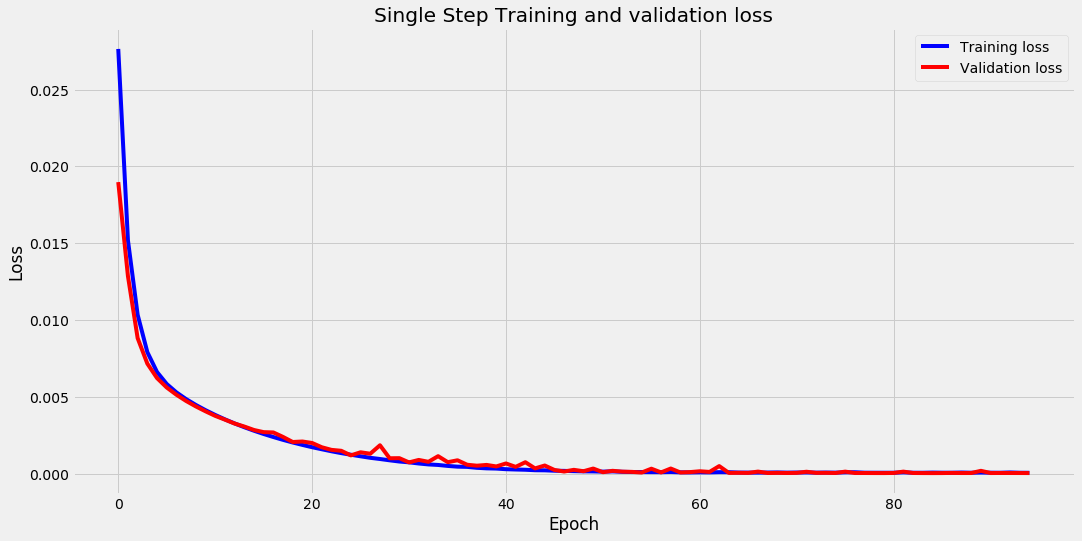

In [30]:
plot_train_history(history, 'Single Step Training and validation loss')

### Values prediction

In [31]:
for x, y in val_univariate.take(1):
    uni_prediction = univariate_ts_model.predict(x)
    print(uni_prediction.shape)

(305, 1)


### Data denormalization

#### Invert difference

In [32]:
inverted_prediction = transformer.inverse_transform(uni_prediction)
inverted_validation = transformer.inverse_transform(y_val_uni)

inverted_prediction_flat = inverted_prediction.flatten()
inverted_validation_flat = inverted_validation.flatten()

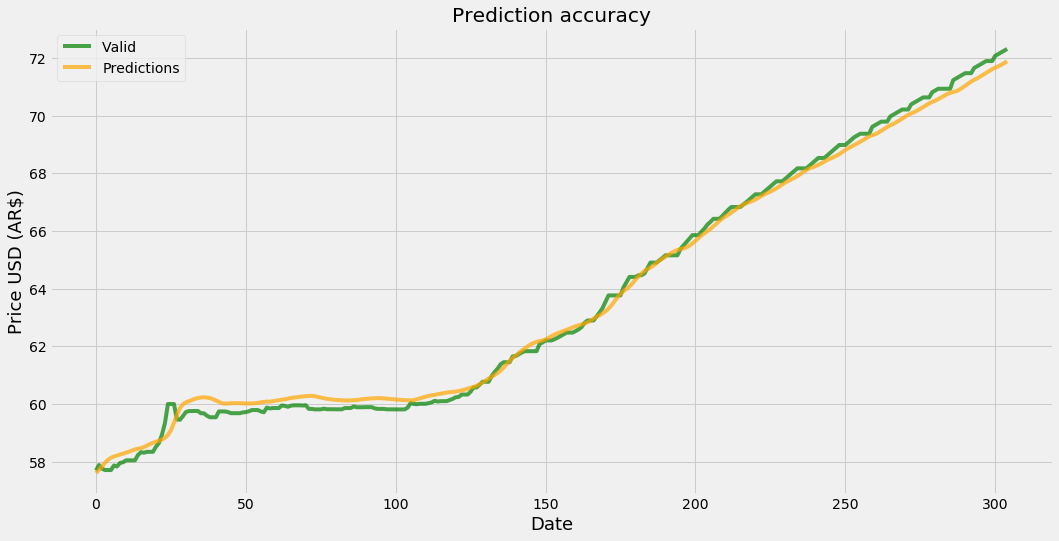

In [33]:
train = univariate_dataframe[:TRAIN_SPLIT]
valid = univariate_dataframe[TRAIN_SPLIT:]
validation = inverted_validation_flat
prediction = inverted_prediction_flat

plt.figure(figsize=(16,8))
plt.title('Prediction accuracy')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD (AR$)', fontsize=18)

plt.plot(validation, c="green", alpha=0.7)
plt.plot(prediction, c="orange", alpha=0.7)

plt.legend(['Valid', 'Predictions'], loc='upper left')
plt.show()

## Save the model and training weights

#### Serialize model to JSON

In [34]:
model_json = univariate_ts_model.to_json()
with open("time_distributed_lstm_model_json.json", "w") as json_file:
    json_file.write(model_json)

#### Serialize weights to HDF5

In [35]:
univariate_ts_model.save_weights("time_distributed_lstm_model_weights.h5")
print("Saved model to disk")

Saved model to disk


#### Or we can save the model and architecture into a single file

In [36]:
univariate_ts_model.save("time_distributed_lstm_model_complete.h5")
print("Saved model to disk")

Saved model to disk


## Trying to predict unknown data to the model

For validation purposes we will be using other data with similar distribution of the training dataset.

In [37]:
new_univariate_dataframe = multivariate_dataframe['futuro_rofex_usd4m']
print(univariate_dataframe.shape)

(6724,)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017001206D48>],
      dtype=object)

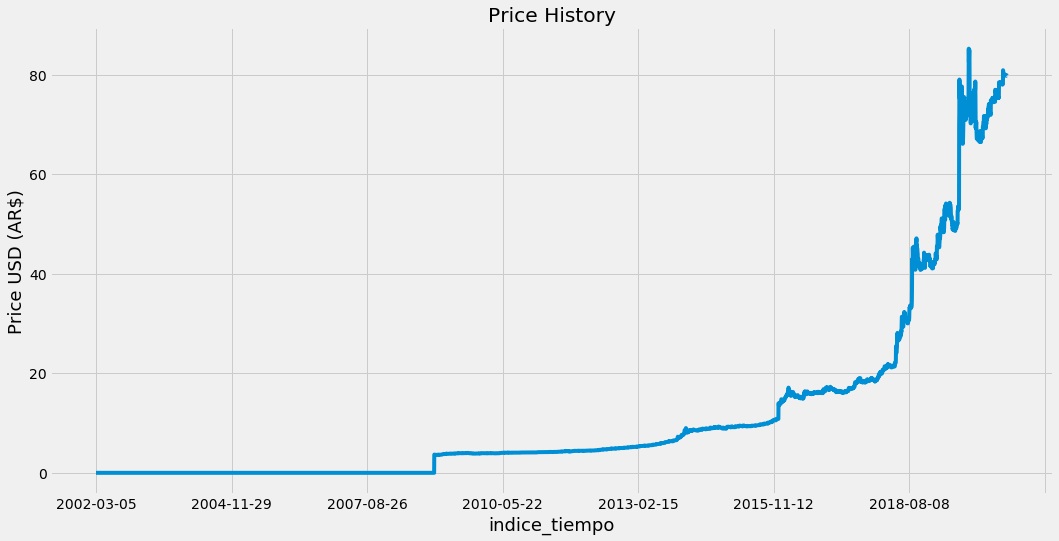

In [38]:
plt.figure(figsize=(16,8))
plt.title('Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD (AR$)', fontsize=18)

new_univariate_dataframe.plot(subplots=True)

In [39]:
new_univariate_dataset = new_univariate_dataframe.values

In [40]:
new_univariate_dataset.shape

(6724,)

This time we will use the entire dataser without spliting into train and validation

In [41]:
pred_x_uni, pred_y_uni = univariate_data(new_univariate_dataset, 0, None, univariate_past_history, univariate_future_target)

In [42]:
pred_x_uni = tf.expand_dims(pred_x_uni, 2)

In [43]:
pred_x_uni.shape

TensorShape([6693, 30, 1, 1])

Preparation of the tensor to predict

In [44]:
pred_univariate = tf.data.Dataset.from_tensor_slices((pred_x_uni, pred_y_uni))
pred_univariate = pred_univariate.batch(7000).repeat()

tf.compat.v1.data.get_output_shapes(val_univariate)

(TensorShape([None, 30, 1, 1]), TensorShape([None, 1]))

Prediction process:

In [45]:
for x, y in pred_univariate.take(1):
    new_prediction = univariate_ts_model.predict(x)
    print(prediction.shape)

(305,)


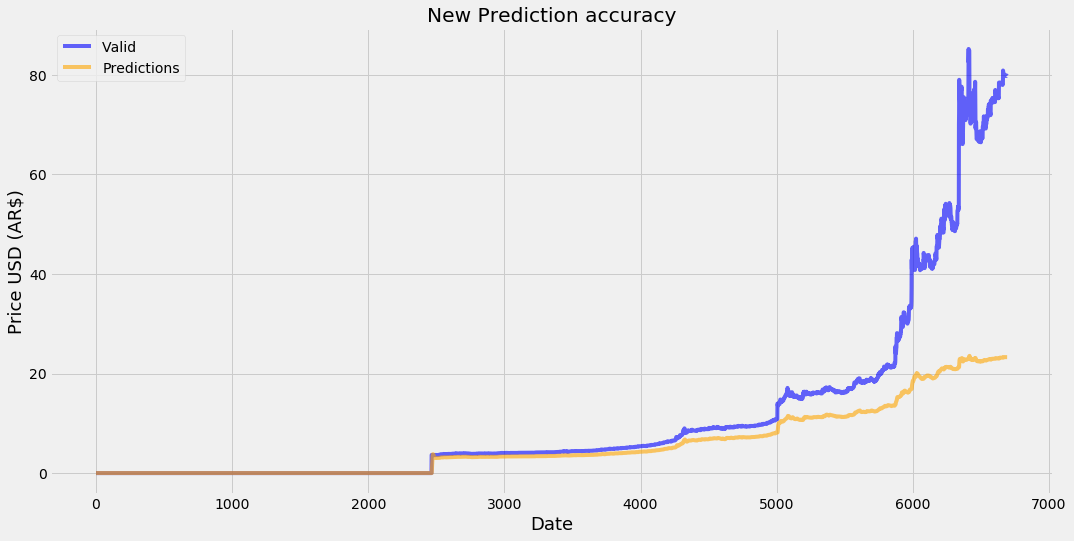

In [46]:
plt.figure(figsize=(16,8))
plt.title('New Prediction accuracy')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD (AR$)', fontsize=18)

plt.plot(pred_y_uni, c="blue", alpha=0.6)
plt.plot(new_prediction, c="orange", alpha=0.6)

plt.legend(['Valid', 'Predictions'], loc='upper left')
plt.show()

##### Thoughts:

To conclude, it can be seen that the trained model respects the trend of the data in the predictions but as time advances, the predictions attenuate. 
This may be due to penalties set to avoid over-specialization of the model when making predictions.
For future improvements, it will evaluate to adjust the penalty of the weights, which may be high.
I will also use various data to verify that the model can generalize its learning and is not specialized in a single data set.